Notes: 
1.The classical processing scales exponentially, so try to stick to smaller images for proof-of-concept testing. I used a 96x96 (9x32x32 blocks) images for my tests.

2.There's still some error, the resulting ED scan seems to be repeating blocks. It probably is some fault in one of the for loops iteration through all the blocks/arrays/lists.

3.You may have to download Pillow to run the program (used for converting image to greyscale without iterating and combining every value)

4.Some functions have been changed from the smaller-version: for example, converting an image to greyscale returns a 2-D instead of 3-D array, and functions like amplitude_encoding have been altered to fit that format.

In [1]:
# Importing standard Qiskit libraries and configuring account
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

#Import Numpy and Matplotlib
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

#Import Pillow for greyscale
import PIL
from PIL import Image

import os
import math

# Detection algorithm works with an NxN matrix
N = 32
#N is a power of 2

In [2]:
#Plot Image
def plot_image(img, title: str):
    plt.title(title)
    
    if img.shape[0] <= 32:
        plt.xticks(range(img.shape[0]))
        plt.yticks(range(img.shape[1]))
    
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()

In [3]:
#Normalize -- squared amplitudes must sum to 1
def amplitude_encode(img_data):
    img_data = img_data.astype(float)    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)

    #assert np.sum(np.square(image_norm)) == 1, f"Sum of amplitudes-squared does not equal one. Sum is: {np.sum(np.square(image_norm))}"

    # Return the normalized image as a numpy array
    return np.array(image_norm)
    

In [4]:
def blockshaped(arr, nrows, ncols):
    # Return an array of shape (n, nrows, ncols) where
    # n * nrows * ncols = arr.size

    # If arr is a 2D array, the returned array should look like n subblocks with
    # each subblock preserving the "physical" layout of arr.
    # Coutesy of Stack Exchange

    #formerly h,w,k. Greyscale only has h,w
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

Raw Image info: (96, 96)
Raw Image datatype: uint8


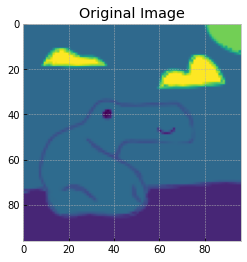

In [5]:
#Open image and convert to greyscale using Pillow library
img_raw = Image.open(r"C:\Users\gsuser\Downloads\capytest.png")
img_grey_raw = img_raw.convert('L')
#img_grey_raw.save('test_grey.jpg')
img_grey = np.asarray(img_grey_raw)

#Image is n blocks of M x K pixels
n, m = img_grey.shape
print('Raw Image info:', img_grey.shape)
print('Raw Image datatype:', img_grey.dtype)

#To create cropSize x cropSize blocks for processing
cropSize = 32

#Image must be a square that can be divided into cropSize x cropSize Blocks
if n != m:
    raise Exception("Image must be square")
if n % cropSize != 0:
    raise Exception(f"Image cannot be converted to an {N} by {N} Blocks")

#Print image
def plot_image_large(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()
    
plot_image_large(img_grey, 'Original Image')


In [6]:
#Creates Blocks of cropSize x cropSize pixels
img = blockshaped(img_grey, cropSize, cropSize)
print(img.shape)

#Size should be (cropSize^2) * (# of blocks)
print(img.size)

(9, 32, 32)
9216


In [16]:
#normalize amplitudes of each block
img_normH = []
img_normV = []
i = 0

for block in img:
    img_normH.append([])
    img_normV.append([])
    img_normH[i] = amplitude_encode(block)
    img_normV[i] = amplitude_encode(block.T)

    i = i + 1



[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]


In [8]:
# qubit amount
# data_qb should be math.ceil(math.log2(N))
data_qb = math.ceil(math.log2(N**2))
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

In [19]:
#circuit computation
svH = []
svV = []

for j in range(0, len(img)):
    # horizontal scan circuit
    print(f"Progress: {j + 1} of {len(img)}")
    qc_h = QuantumCircuit(total_qb)
    qc_h.initialize(img_normH[j], range(1, total_qb))
    qc_h.h(0)
    qc_h.unitary(D2n_1, range(total_qb))
    qc_h.h(0)

    # vertical scan circuit
    qc_v = QuantumCircuit(total_qb)
    qc_v.initialize(img_normV[j], range(1, total_qb))
    qc_v.h(0)
    qc_v.unitary(D2n_1, range(total_qb))
    qc_v.h(0)

    # Combine both circuits
    circ_list = [qc_h, qc_v]

    #---#

    # run simulator
    svH.append([])
    svV.append([])

    back = Aer.get_backend('statevector_simulator')
    results = execute(circ_list, backend=back).result()
    svH[j] = results.get_statevector(qc_h)
    svV[j] = results.get_statevector(qc_v)

    j = j+1

Progress: 1 of 9
Progress: 2 of 9
Progress: 3 of 9
Progress: 4 of 9
Progress: 5 of 9
Progress: 6 of 9
Progress: 7 of 9
Progress: 8 of 9
Progress: 9 of 9


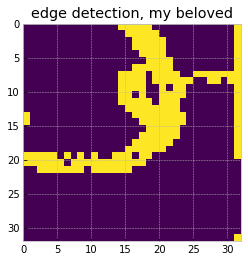

In [43]:
# Classical postprocessing and plotting

# lambda function for binary value thresholding
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

scanTotalH = []
scanTotalV = []
k = 0

for listH, listV in zip(svH, svV):

    # select odd states (lists) from raw statevectors and 
    # reshape column vector to NxN
   
    scanTotalV.append([])
    scanTotalH.append([])
    scanTotalV[k] =     edge_scan_v = np.abs(np.array([1 if threshold(listV[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(cropSize, cropSize).T
    scanTotalH[k] =     edge_scan_h = np.abs(np.array([1 if threshold(listH[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(cropSize, cropSize)

    k = k+1

#plot_image_large(scanTotalH[7], "edge detection, my beloved")

In [55]:
img_full = []
print(scanTotalH.shape)

for j in range(0, int(n/cropSize)):
    print('o')
    for i in range(0, int(n/cropSize)):
        print('i')
        temp = scanTotalH[i + (j*int(n/cropSize))] | scanTotalV[i + (j*int(n/cropSize))]
        if i == 0:
            img_row = temp
        else:
            img_row = np.concatenate( (img_row, temp), axis = 1)

    if j == 0:
        img_full = img_row
    else:
        img_full = np.concatenate( (img_full, img_row), axis = 0)

print(img_full.shape)

    

(9, 32, 32)
o
i
i
i
o
i
i
i
o
i
i
i
(96, 96)


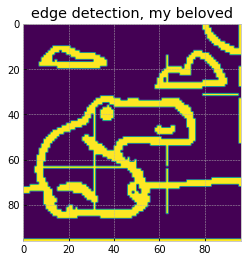

In [56]:

plot_image_large(img_full, "edge detection, my beloved")